# Notebook 15: Clustering with Scikit Learn

## Learning goals
The goal of this notebook is to familiarize the reader with how to implement clustering algorithms with the scikit-learn package. After this notebook, the reader should understand how to implement common clustering algorithms using Scikit learn and use Principal Component Analysis (PCA) to visualize clustering in high-dimensions. Moreover our goal is to convey to the reader some of the intuitions concerning clustering validation, i.e. determining which clustering assignment is best.

## Practical clustering methods
We will look at some of the clustering methods we introduced in the review (DBSCAN, $K$-means and hierarchical clustering) using [scikit-learn](http://scikit-learn.org/stable/index.html) implementation. We will study our favorite dataset (Ising model) along with some artificial datasets. The first half of the notebook here is based on the Scikit learn example found [here](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py). More generally, the reader is encouraged to explore the incredible scikit learn [example library](http://scikit-learn.org/stable/auto_examples/index.html).


## Comparing various clustering methods (visual inspection)

This section in the notebook compares different clustering methods on a variety of datasets. All methods are implemented using Scikit Learn. The code is from the aforementioned [example](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py). The reader is encouraged to explore the details of the implemented methods. 

Automatically created module for IPython interactive environment


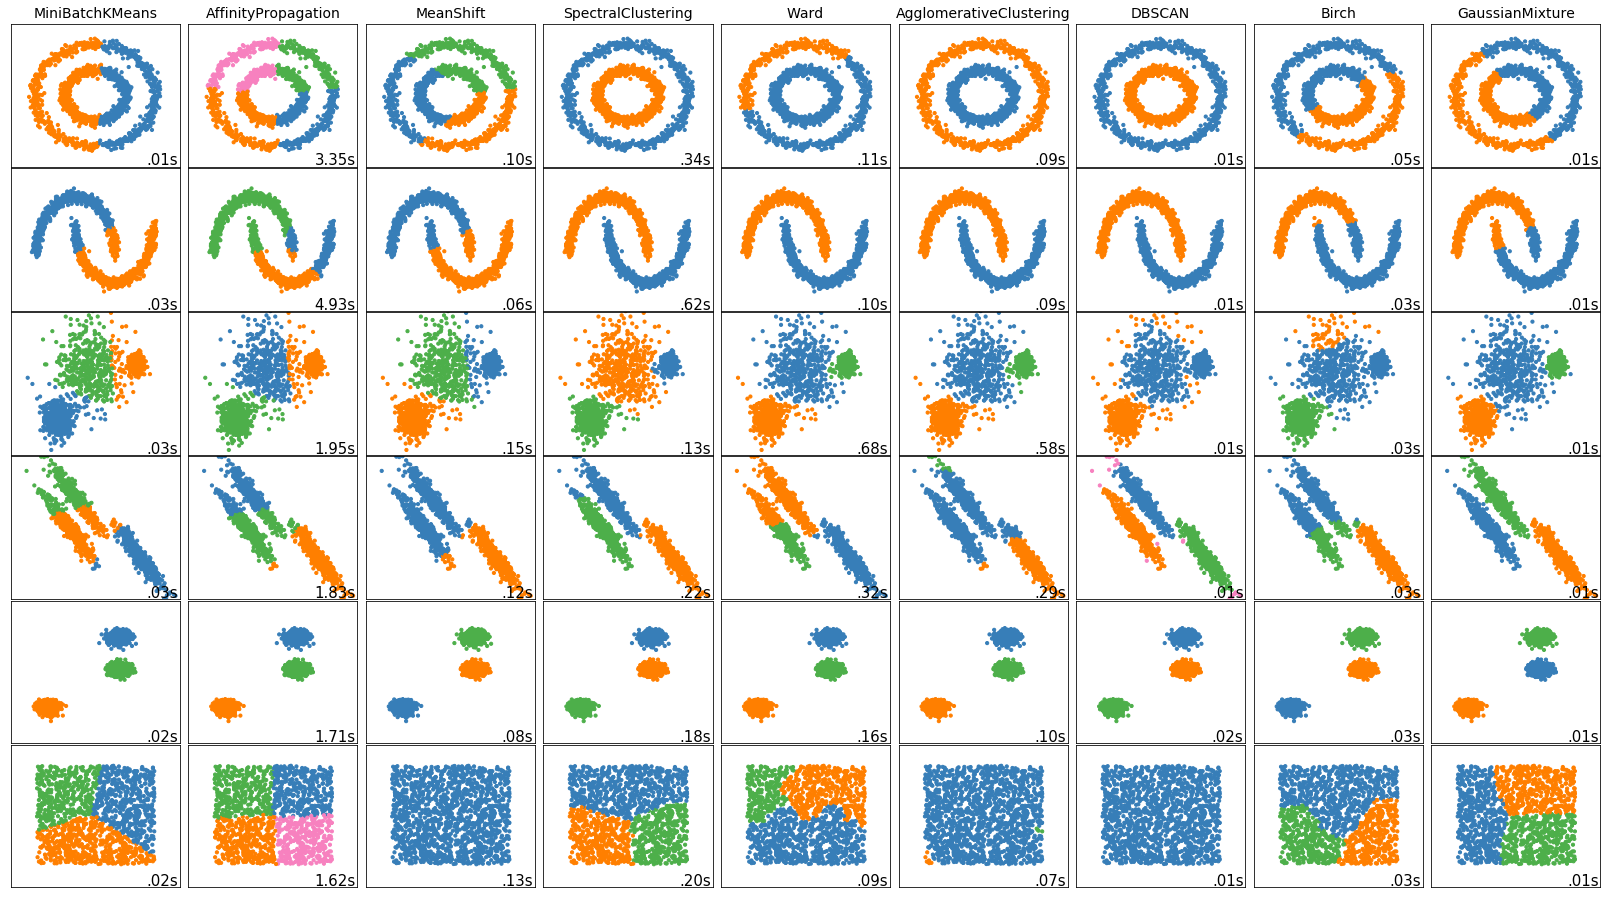

In [1]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
plt.rc('font',**{'size':16})

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
%matplotlib inline
np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 5, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')
    
    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=14)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

# Remarks and discussion

In this simple setting, DBSCAN outperforms the other methods both in computational time and in prediction accuracy for almost all cases. DBSCAN fails only for the 3rd dataset (from the top). Note the wide range of qualitatively different datasets used. When tuning a clustering method it is important to understand what the implicit assumption of the clustering method are. For instance, methods based on density (local information), will typically fare well at clustering topological datasets (row 1 and 2) since points are connected from neighbor to neighbor. At the same time, methods based on long-distance information ($K$-means for instance), will typically perform poorly in such instances. Density-based methods will, however, have more difficulty at dealing with datasets with large fluctuations in the density distribution of the dataset (3rd row). Another drawback of density based methods is that they do not generalize well to high-dimensional space due to large sampling noise in the density estimates. 

## (Optional) Auxiliary clustering package from Alex Day (useful also for plotting)

(Required) Install the package from https://github.com/alexandreday/fast_density_clustering given the instructions provided.

Two examples are provided in the folder example. Here we reproduce the first example:

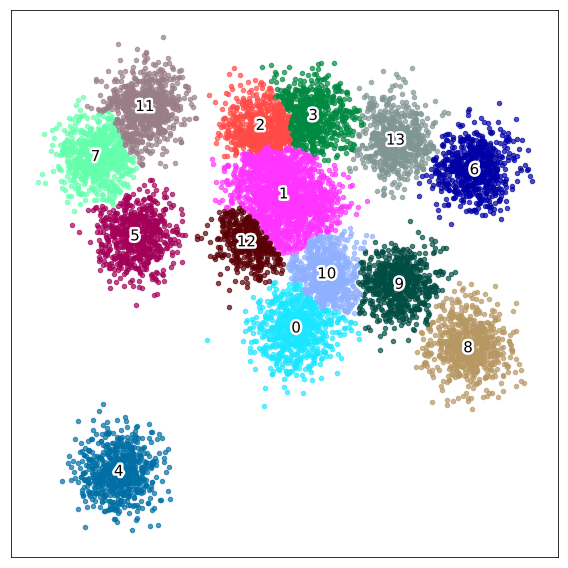

In [33]:
from fdc import FDC # package installed
from sklearn.datasets import make_blobs
from fdc import plotting
import pickle
import numpy as np

n_true_center = 15

np.random.seed(0)

print("------> Example with %i true cluster centers <-------"%n_true_center)

X, y = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture

model = FDC(eta=0.05, test_ratio_size=0.1) # set parameters

model.fit(X) # performing the clustering

plt.figure(figsize=(8,8))
plotting.cluster_w_label(X, model.cluster_label) # plot clustering assignments found by algorithm

# Note

Fast density clustering (FDC) is based on search for local density modes of the density distribution (see for instance *A. Rodriguez and L. Alessandro, **Science** 2014*). The density distribution is computed using Gaussian kernel density estimates where the bandwidth is tuned by cross-validation. Two main parameters control the behavior of the algorithm:

1. `eta` - the noise threshold for which two modes of the density are considered different. A small `eta` means a large sensitivity to noise fluctuations.
2. `test_ratio_size` (ratio, number between 0 and 1) -  size of the test set used for cross-validation of the density model. A `test_ratio_size` closer to 1 yields to smoother density maps. 

## Ising Dataset

We now explore how to cluster the Ising dataset and visualize the results using PCA.

First let's load the Ising dataset using the following function:

In [8]:
import pickle,os
def read_t(root="./"):
    data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=All.pkl','rb'))
    return np.unpackbits(data).astype(int).reshape(-1,1600)

In [9]:
X = read_t(root=os.path.expanduser('~')+'/Documents/MachineLearning/nb15/')

Let's perform principal component analysis (PCA) on the Ising dataset. We start by downsampling and then perform PCA using sklearn's implementation:

In [10]:
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
plt.rc('font',**{'size':40})
%matplotlib inline

np.random.seed(0) # fixing the random seed

idx = np.arange(len(X))
tval = np.hstack([t]*10000 for t in np.arange(0.25,4.01,0.25)) # Temperature values for each sample
rand = np.random.choice(idx, size=5000, replace=False)
Xdownsample = X[rand]
modelPCA = PCA(n_components=2)
XPCA = modelPCA.fit_transform(Xdownsample)
component1 = modelPCA.components_[0]
tval = tval[rand]

/Users/Katie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


Let's plot the PCA results

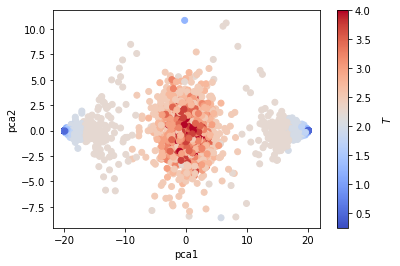

In [11]:
plt.scatter(XPCA[:,0],XPCA[:,1],c=tval,cmap="coolwarm") 
plt.xlabel('pca1')
plt.ylabel('pca2')
cb = plt.colorbar()
cb.set_label(label='$T$',labelpad=10)
plt.show()

We see that that three clusters are found. We can also inspect the PCA-1 principal component:

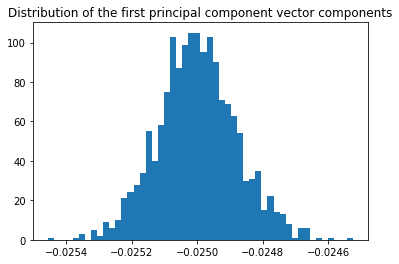

In [12]:
plt.hist(component1,bins=50)
plt.title('Distribution of the first principal component vector components')
plt.show()

# Discussion

The components of the first PCA vector are tightly distributed around a single value. This implies that the PCA vector is essentially a constant vector. Indeed it corresponds to the magnetization order parameter. The first component yields the magnetization order parameter because PCA finds linear combinations of the features that have the largest variance. Clearly the magnetization satisfies this condition (since it goes from 0 to 1 as temperature is varied).

Since we already know how many clusters we are looking for, let's use $K$-means to obtain those clusters rapidly.

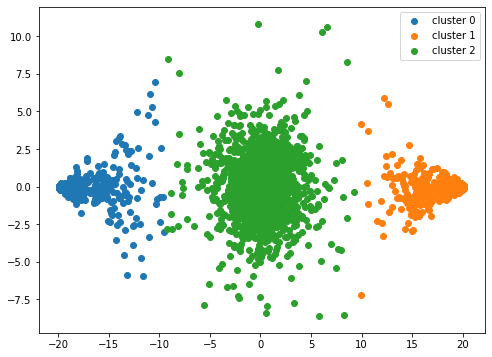

In [13]:
from sklearn.cluster import k_means

xcenter, ypred, _ = k_means(XPCA,n_clusters=3)
Xdict = {}
plt.figure(figsize=(8,6))
for y in np.unique(ypred):
    pos = (y==ypred)
    Xdict[y]=XPCA[pos] # store for later
    plt.scatter(XPCA[pos,0], XPCA[pos,1], label='cluster %i'%y)

plt.legend(loc='best')
plt.show()

Let's now look at the mean of each cluster. Since we have obtained the cluster labels, we can go back to the original space:

In [14]:
mean={'cluster_%i'%y : np.mean(Xdownsample[(y==ypred)]) for y in [0,1,2]}

Note that the magnetization are obtained by multiplying by 2 and subtracting 1:

In [15]:
mean['cluster_0']*2-1, mean['cluster_1']*2-1, mean['cluster_2']*2-1

(0.9542431850789097, -0.9580437178545187, -0.0004231625835189323)

Thus we found that left- and right-most clusters are well magnetized (ordered phase). The middle cluster is not magnetized and corresponds to the high-temperature states.

# Clustering accuracy and clustering algorithm parameters:

## Exercises:

1. How would you define what a good cluster or a good clustering assignment is?

Answer: The specific mode of measurement depends on the clustering method, but overall, good clustering is defined by having high similarity among data points within the same cluster but very low similarity between different clusters.

2. Given that you have access to ground truth labels, can you define a metric to measure clustering accuracy?

Answer: If you have access to the labels, then your metric can be basically an efficiency measurement: how many times did your clustering algorithm correctly identify a data point for a specific group versus the total number of data points.

3. Can you devise a metric that does not use ground truth labels? Is that metric monotonic in the number of clusters?

Answer: A metric that doesn't depend on labeled data instead depends on the ability of the algorithm to find hidden patterns, so if your clustering algorithm uses more of the hidden variables, it's perhaps more likely to be better at clustering.

4. Can you think of a way of leveraging supervised learning to construct a measure of clustering accuracy (without access to ground truth labels)?

One way to quantitatively measure the performance of a clustering method is to compare the predicted labels to the ground-truth labels (given that those are available). Here we will use the normalized mutual information (see https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html for more discussion on the subject and other possible metrics) to perform such comparison. As we will see, when doing clustering, there is usually no free lunch: if one chooses the wrong set of parameters (which can be quite sensitive), the clustering algorithm will likely fail or return a trivial answer (for instance all points assigned to the same cluster).  

In [16]:
from collections import OrderedDict

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

Consider again the 2D Gaussian mixture we produced above:

------> Example with 15 true cluster centers <-------


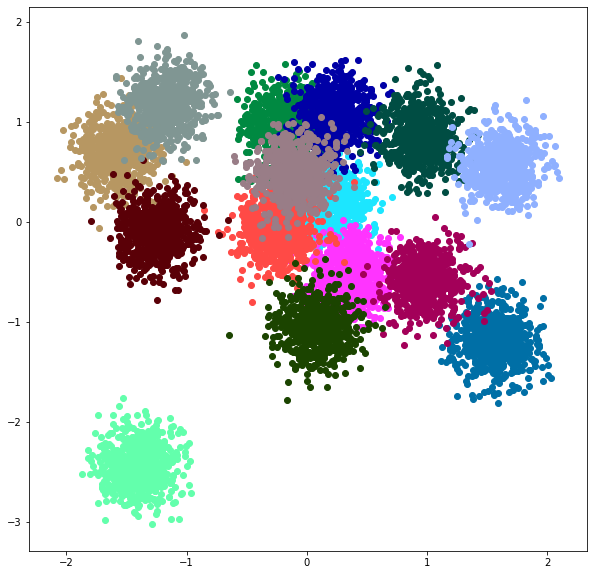

In [17]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

n_true_center = 15

np.random.seed(0)

print("------> Example with %i true cluster centers <-------"%n_true_center)

X, y = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X = StandardScaler().fit_transform(X)

cpalette = ["#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]

def plot_clustering(X,y):
    plt.figure(figsize=(10,10))
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        plt.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)])
    plt.show()

plot_clustering(X,y)

Let's apply simple clustering methods to this dataset and measure their accuracy.

# $K$-means:

$K$-means is a simple clustering methods based on minimizing the inertia of clusters. One tries to find $K$ cluster centers with points tightly distributed around them. $K$-mean has the advantage of being scalable to very large datasets. One of the two main problems with $K$-means is that
    1. K has to be fixed by the user 
    2. K-means can only deal with "convex" clusters

We can measure the performance of K-means by thinking about the *distortion*- the square distance of each point from the centroid defining the cluster. This is the objective function that K-means tries to optimize.

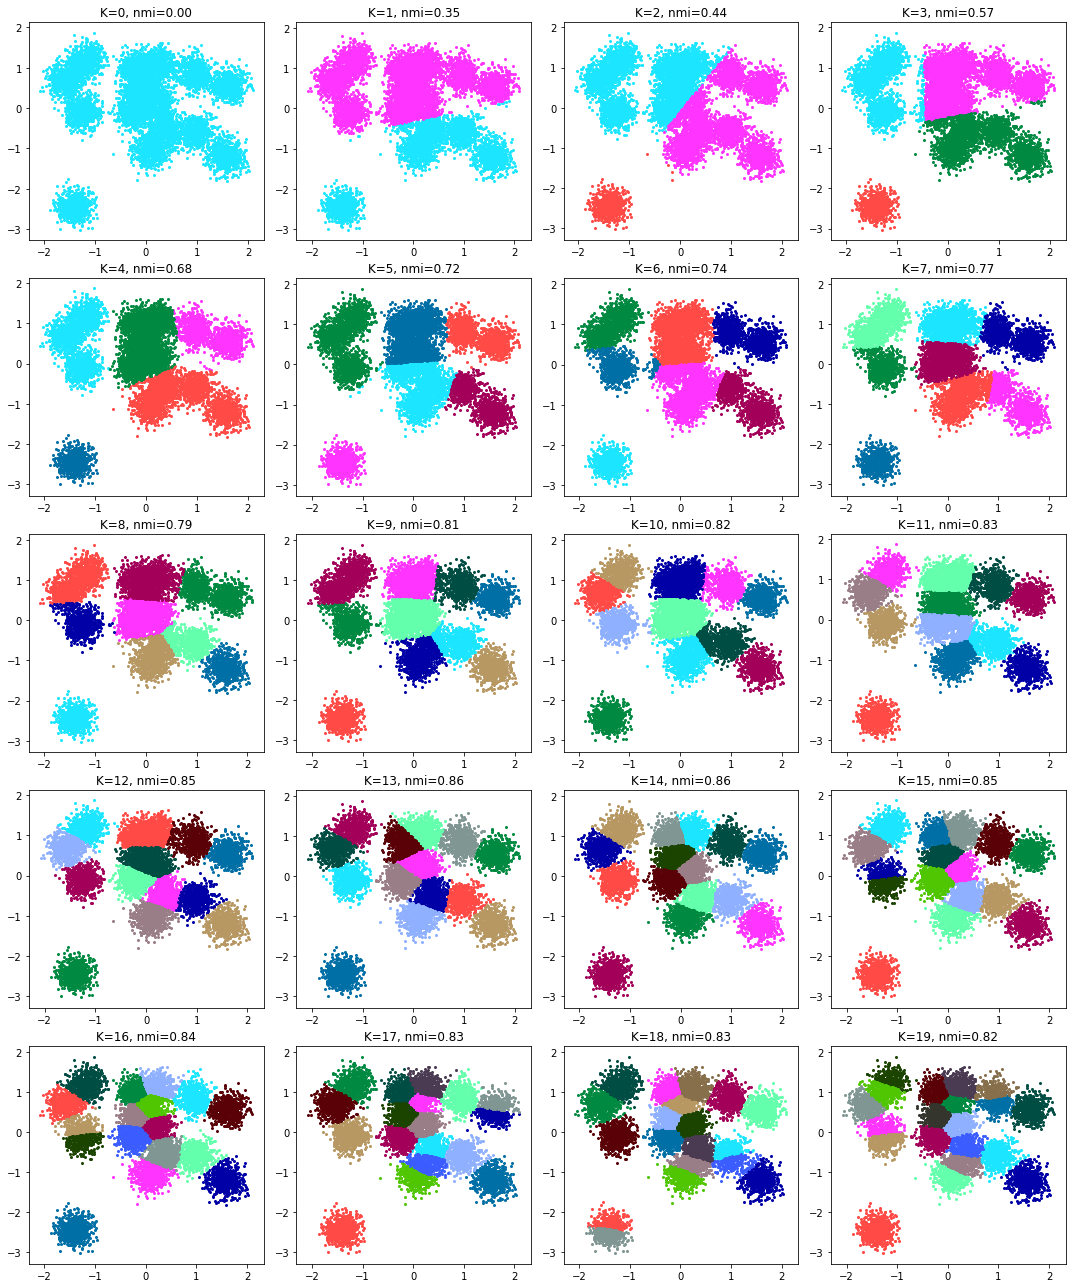

In [18]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=4)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(0)
n_true_center=15
X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X = StandardScaler().fit_transform(X)

K_range = np.arange(20).reshape(5,4)
fig, ax = plt.subplots(K_range.shape[0], K_range.shape[1], figsize=(15,18))
distortion = []
for i in range(K_range.shape[0]):
    for j in range(K_range.shape[1]):
        model = KMeans(n_clusters=K_range[i,j]+1)
        model.fit(X)
        y = model.labels_
        plotting_ax(X, y, ax[i,j])
        nmi=NMI(y, ytrue)
        ax[i,j].set_title('K=%i, nmi=%.2f'%(K_range[i,j],nmi))
        distortion.append(model.inertia_)
plt.tight_layout(h_pad=0.5)
plt.show()

Finally, let's plot the distortion against the number of clusters. 

<b>Exercise</b> Before you run the code below, Make a prediction for what you think this will look like and why?

Answer: Exponential decrease: the more clusters you have, the less distortion there is.

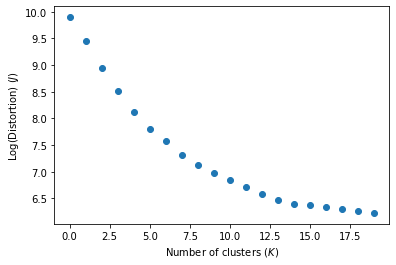

In [19]:
plt.scatter(K_range.flatten(), np.log(distortion))
plt.xlabel('Number of clusters ($K$)')
plt.ylabel('Log(Distortion) ($J$)')
plt.show()

# Discussion

We see that $K$-Means does a great job at dealing with Gaussian mixtures of equal variances. The normalized mutual information is maximized at $K=15$. However, one usually does not have access to ground-truth labels. Many simple measures of clustering can be devised to measure clustering accuracy (for instance the distortion, see above). These however tend to be monotonic in the number of clusters. Maximizing/minimizing such metrics will lead 
to trivial solutions. Instead one usually tries to find a point of inflexion (or kink) in the metric, which signifies a major change in the clustering algorithm and can be sometimes associated with the regime of good solutions.

# Exercises
1. In the case where clusters are non-convex, do you think one can still use $K$-means to find good solutions?

Answer: No, $K$-means specifically requires convex problems.

2. How does $K$-means relate to latent variable models (where a probability is fitted to the data)?

Answer: $K$-means assumes the data follows multiple Gaussians (Gaussian Mixture Model).

3. In the case of non-convex clusters, can you think of a way of using $K$-means to yield good clustering assignments (hint : consider merging clusters)?

Answer: I can imagine that you re-parameterize your data such that it is convex.

# Density based clustering: DBSCAN
Here we sweep over the main parameters of DBSCAN and compute the normalized mutual information for every assignment found.

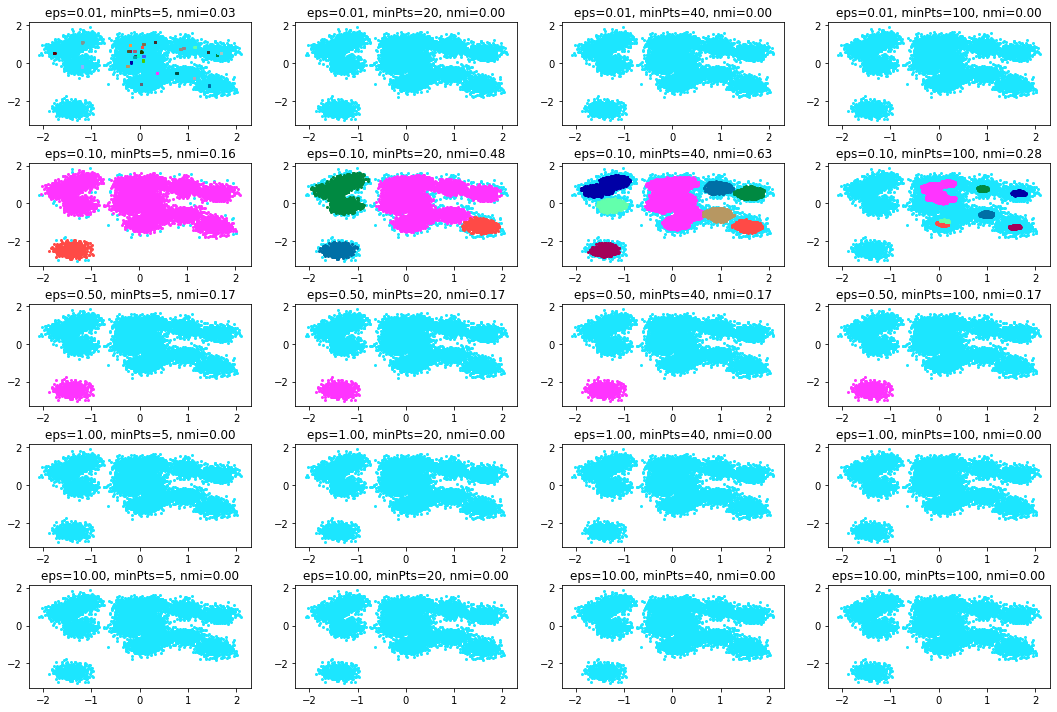

In [21]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=4)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(0)
n_true_center=15
X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X = StandardScaler().fit_transform(X)

eps_range = [0.01,0.1,0.5,1.0,10.]
min_sample_range = [5,20,40,100]
fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,10))
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y = model.labels_
        plotting_ax(X,y,ax[i,j])
        nmi=NMI(y, ytrue)
        ax[i,j].set_title('eps=%.2f, minPts=%i, nmi=%.2f'%(eps,min_samples,nmi))
plt.tight_layout(h_pad=0.5)
plt.show()

# Discussion

### Parameters

DBSCAN does a great job of clustering when the parameters are well chosen. `minPts` is responsible for determining what an outsider is (i.e. if a point has less than `minPts` in its epsilon neighborhood, it is not a core-point). `eps` tunes the size of the neighborhood of each point which is just a circle of radius `eps`. 

### Number of clusters

Note also that obtaining the exact number of clusters or the perfect cluster assignment is usually not what is sought in clustering (since it is usually not possible to do this). Indeed, if two Gaussians (representing two different clusters) have a large overlap, the density function corresponding to the sum of the two Gaussians will effectively look like a single Gaussian and it makes sense to predict a unique cluster in this situation. Given the available information, there is no statistically significant way of separating those two clusters. This scale of separation, i.e. what to consider noise and what to consider distinct clusters, is usually encoded in one of the parameters of density based clustering algorithms.

# Exercises:

1. How would you estimate the density of a data point ?

Answer: I'm not sure exactly what this question is asking (i.e. how would you pick minPts or basically how does DBSCAN work), but you can estimate the density of a data point by looking at a neighborhood of radius $\epsilon$ and counting the number of points near that core point.

2. Try and construct a density map of the dataset above. 
3. Visualize this density map by coloring each point with their density. Did you have to introduce a parameter that influences the density estimate ? In the case of DBSCAN, this would be the `eps` parameter.
4. (if yes !) Try changing this parameter and see how it changes the map. 
5. Can you tune this parameter such that the density map clearly shows 15 distinct clusters ?

Answer: I tried (see below). The balance must be struck between `eps` and minPts, but it's really freaking hard to isolate the blobs at ~(0,1). The closest I could get is 13 different clusters.

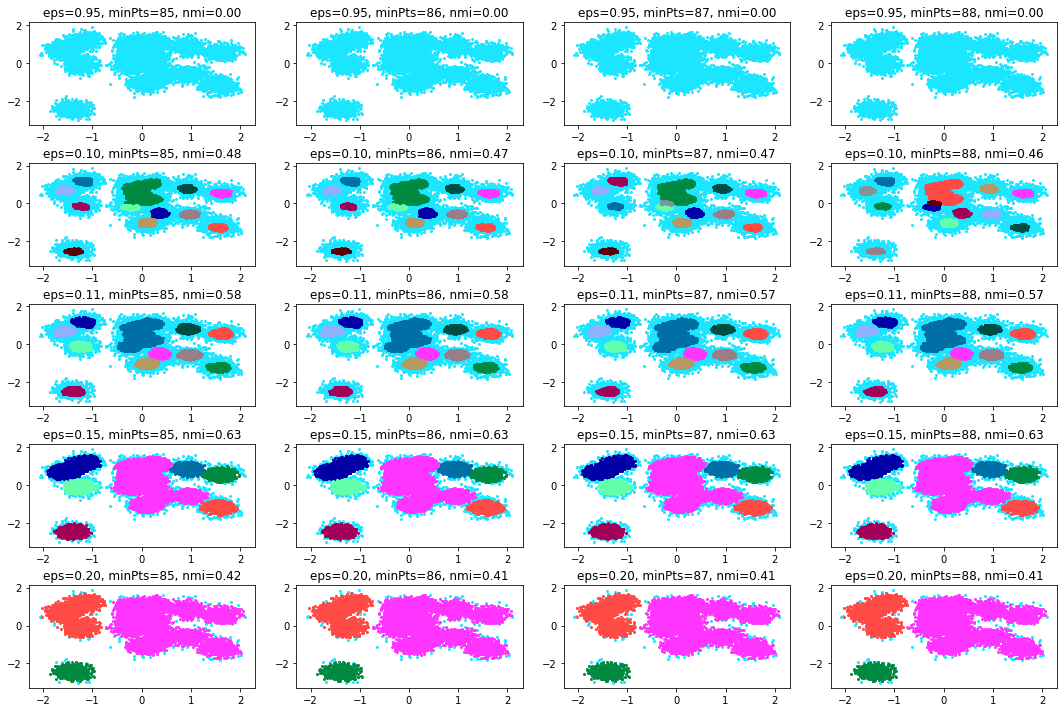

In [56]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=4)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(0)
n_true_center=15
X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X = StandardScaler().fit_transform(X)

eps_range = [0.95,0.1,0.11,0.15,0.2]
min_sample_range = [85,86,87,88]
fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,10))
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y = model.labels_
        plotting_ax(X,y,ax[i,j])
        nmi=NMI(y, ytrue)
        ax[i,j].set_title('eps=%.2f, minPts=%i, nmi=%.2f'%(eps,min_samples,nmi))
plt.tight_layout(h_pad=0.5)
plt.show()